In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
## Zmienne ciągłe
from sklearn.preprocessing import( 
                    StandardScaler, 
                    MinMaxScaler,
                    Normalizer
)
## Zmienne kategoryczne
from sklearn.preprocessing import( 
                    OrdinalEncoder, 
                    OneHotEncoder
)
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Przygotowanie danych do nauki
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import (
                LeaveOneOut,
                cross_val_score
)
# Modele
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#Ulepszanie modelu
from sklearn.model_selection import( 
                GridSearchCV,
                learning_curve
                                   
)
from sklearn.metrics import (
                accuracy_score,
                roc_auc_score,
                recall_score,
                confusion_matrix,
                plot_roc_curve,
                roc_curve
)
                             
#Zapisywanie modeli
import pickle

#Animacja progressbar
from tqdm.notebook import tqdm_notebook

# Ładowanie Danych

In [2]:
df_raw = pd.read_csv('./data_set/preprocessing/hd_dataSet.csv')
df_raw.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,male,typical angina,145.0,233.0,greater than 120mg/ml,left ventricular hypertrophy,150.0,no,2.3,downsloping,0.0,fixed defect,0
1,67.0,male,asymptomatic,160.0,286.0,lower than 120mg/ml,left ventricular hypertrophy,108.0,yes,1.5,flat,3.0,normal,1
2,67.0,male,asymptomatic,120.0,229.0,lower than 120mg/ml,left ventricular hypertrophy,129.0,yes,2.6,flat,2.0,reversable defect,1
3,37.0,male,non-anginal pain,130.0,250.0,lower than 120mg/ml,normal,187.0,no,3.5,downsloping,0.0,normal,0
4,41.0,female,atypical angina,130.0,204.0,lower than 120mg/ml,left ventricular hypertrophy,172.0,no,1.4,upsloping,0.0,normal,0


In [3]:
df = df_raw.copy()

# Podział danyhc na zestaw testowy i treningowy

Macierz cech: (297, 13)
Wektor atrybutu docelowego: (297,)
X_train:(237, 13)
X_test:(60, 13)
y_train:(237,)
y_test:(60,)


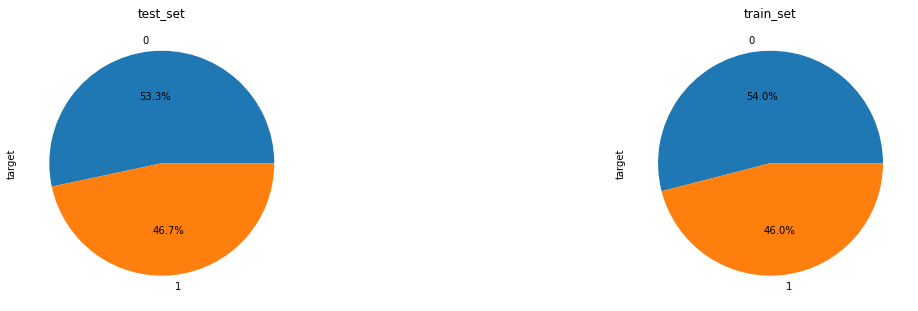

In [4]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
print(f'Macierz cech: {X.shape}\nWektor atrybutu docelowego: {y.shape}')

data = train_test_split(X, y, test_size=0.2, random_state = 0, stratify=y)
X_train = data[0]
X_test = data[1]
y_train = data[2]
y_test = data[3]

print(f'X_train:{X_train.shape}')
print(f'X_test:{X_test.shape}')
print(f'y_train:{y_train.shape}')
print(f'y_test:{y_test.shape}')

print_target = [(y_test,'test_set'),(y_train,'train_set')]
plt.figure(figsize=(20,30))
for i,data in enumerate(print_target):
    plt.subplot(5,2,i+1)
    data[0].value_counts().plot(kind='pie', autopct="%.1f%%", title = data[1])

# Model Bazowy

In [5]:
base_model = DummyClassifier()
base_model.fit(X_train,y_train)
print(f'{base_model.score(X_test,y_test)}')

#Macierz pomylek
y_pred_lr = base_model.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, y_pred_lr)
print("confusion matrix")
print(lr_conf_matrix)

0.5333333333333333
confusion matrix
[[32  0]
 [28  0]]


# Badanie algorytmów

## Przygotowanie listy algorytmów do badania wraz z parametrami regularyzacji

In [6]:
# klasyfikatory                            
classifiers = [
    (LogisticRegression(solver = 'liblinear'), # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
     {'classifier__C': [0.01,0.1,1,10,100],
      'classifier__penalty': ['l1', 'l2'] }
    ),
    (KNeighborsClassifier(),
     {'classifier__n_neighbors': [i for i in range(1,11)], 
      'classifier__metric' : ['minkowski', 'euclidean', 'manhattan']}
    ), 
    (DecisionTreeClassifier(),
     {'classifier__criterion': ['gini', 'entropy'], 
      'classifier__max_depth' : [None,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,150,200],
      'classifier__max_leaf_nodes': [None,2,3,4,5,6,7,8,9,10]}
    ),
    (RandomForestClassifier(),
     {'classifier__criterion': ['gini', 'entropy'], 
      'classifier__max_depth' : [None,2,3,4,5,6,7,8,9,10]}
    ),
    (SVC(),
     [{'classifier__kernel': ['rbf'], 'classifier__C': [0.01, 0.01, 0.1, 1, 10, 100], 
      'classifier__gamma': [0.01, 0.01,0.1, 1, 10, 100]
     }, 
     {'classifier__kernel': ['linear'], 
      'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}
     ]
    )
]

# transformatory dla kolumn liczbowych
scalers = [StandardScaler(), MinMaxScaler(), Normalizer(), None]
 
# transformatory dla kolumn kategorycznych
cat_transformers = [OrdinalEncoder(), OneHotEncoder(drop='first')]

## Przygotowanie transforamtorów oraz potoków 

In [7]:
#Potok odpowiadający za transformacje warotści numerycznych
transformer_numerical = Pipeline(steps = [
                                ('num_trans', None)
                                ])

#Potok odpowiadający za transformacje wartości kategorycznych 
transformer_categorical = Pipeline(steps = [
                                  ('cat_trans', None)
                                  ])

#Transformator odowiadający za zmiane kolumn
preprocessor = ColumnTransformer(
    transformers=[
        ('col_numerical', transformer_numerical, selector(dtype_exclude="object")),
        ('col_categorical', transformer_categorical, selector(dtype_include="object"))])

# Testowanie działania metod 
print(f'Numerczyne kolumny: {selector(dtype_exclude="object")(X_test)}\n')
print(f'Dyskretne kolumny: {selector(dtype_include="object")(X_test)}')

print('\n\t\t\t=== SPRAWDZANIE POPRAWNEJ TRANSFORMACJI ===')
transformer_params = {
    'col_numerical__num_trans': StandardScaler(),
    'col_categorical__cat_trans': OneHotEncoder(drop='first')
    }
test_preprocessor = preprocessor
test_preprocessor.set_params(**transformer_params)

models_df = pd.DataFrame()
models_df = models_df.append(pd.DataFrame(test_preprocessor.fit_transform(X_train)))
models_df.head()

Numerczyne kolumny: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

Dyskretne kolumny: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

			=== SPRAWDZANIE POPRAWNEJ TRANSFORMACJI ===


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.629846,1.113910,-0.164650,0.948051,-0.137847,-0.725697,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,-1.033677,-1.130357,-1.692675,-0.487795,-0.926126,-0.725697,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.146465,0.523313,-0.871361,0.251883,1.789057,-0.725697,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.479169,-1.248476,0.102755,0.425925,-0.926126,-0.725697,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.518944,0.228015,-0.279251,0.512946,-0.488193,-0.725697,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


## Trenowanie modelu

In [8]:
#Tabela na wyniki
models_df = pd.DataFrame()

loo = LeaveOneOut() 

best_models = {}
#pomocniczy potok
pipe = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('classifier', None)
            ])

touple_with_transform = [(num_t, cat_t) for num_t in scalers for cat_t in cat_transformers]

for model,param_grid in tqdm_notebook(classifiers,desc='Algorithm Study'):
    for num_tr,cat_tr in tqdm_notebook(touple_with_transform, 
                                       desc=f'Transformations Study for {model.__class__.__name__}'):
        pip_params = {
            'preprocessor__col_numerical__num_trans': num_tr,
            'preprocessor__col_categorical__cat_trans': cat_tr,
            'classifier': model}
        
        pipe.set_params(**pip_params)
        try:
            #Trening modelu
            grid_search = GridSearchCV(pipe, param_grid, cv=10, scoring='accuracy' )
            grid_search.fit(X_train, y_train)

            #Pozyskanie potrzebnych danych
            train_score_cv = grid_search.best_score_
            std_train_score_cv = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
            y_predict = grid_search.predict(X_test)
            test_score = accuracy_score(y_test, y_predict)#grid_search.score(X_test, y_test)
            recall = recall_score(y_test, y_predict, average=None)
            auc = roc_auc_score(y_test, y_predict)
            
            #Zapisywanie każdego obiektu
            param_dict = {
                        'model': model.__class__.__name__,
                        'num_trans': num_tr.__class__.__name__,
                        'cat_trans': cat_tr.__class__.__name__,
                        'train_score': train_score_cv,
                        'std_train_score': std_train_score_cv,
                        'test_score': test_score,
                        'recall_test_1':recall[1],
                        'recall_test_0':recall[0],
                        'AUC': auc
            }
            #Zapisywanie "najlepszego" modelu do tablicy
            if model.__class__.__name__ in best_models:
                 if best_models[model.__class__.__name__][1] < test_score:
                        best_models[model.__class__.__name__]= (grid_search.best_estimator_, test_score)                       
            else:
                best_models[model.__class__.__name__]= (grid_search.best_estimator_, test_score)
                
            # Dodanie 
            models_df = models_df.append(pd.DataFrame(param_dict, index=[0]))
        except:
            print(f'W trakcie trenowania {model.__class__.__name__} nastąpił błąd')
            
models_df.reset_index(drop=True, inplace=True)

Algorithm Study:   0%|          | 0/5 [00:00<?, ?it/s]

Transformations Study for LogisticRegression:   0%|          | 0/8 [00:00<?, ?it/s]

Transformations Study for KNeighborsClassifier:   0%|          | 0/8 [00:00<?, ?it/s]

Transformations Study for DecisionTreeClassifier:   0%|          | 0/8 [00:00<?, ?it/s]

Transformations Study for RandomForestClassifier:   0%|          | 0/8 [00:00<?, ?it/s]

Transformations Study for SVC:   0%|          | 0/8 [00:00<?, ?it/s]

## Wyniki algorytmów cz.1

In [9]:
models_df[models_df['model']== 'DecisionTreeClassifier'].sort_values('test_score', ascending=False)

,model,num_trans,cat_trans,train_score,std_train_score,test_score,recall_test_1,recall_test_0,AUC
18,DecisionTreeClassifier,MinMaxScaler,OrdinalEncoder,0.797101,0.063011,0.80,0.785714,0.81250,0.799107
20,DecisionTreeClassifier,Normalizer,OrdinalEncoder,0.813587,0.068003,0.80,0.750000,0.84375,0.796875
21,DecisionTreeClassifier,Normalizer,OneHotEncoder,0.784601,0.066633,0.80,0.821429,0.78125,0.801339
22,DecisionTreeClassifier,NoneType,OrdinalEncoder,0.797101,0.063011,0.80,0.785714,0.81250,0.799107
16,DecisionTreeClassifier,StandardScaler,OrdinalEncoder,0.800362,0.109189,0.75,0.714286,0.78125,0.747768
17,DecisionTreeClassifier,StandardScaler,OneHotEncoder,0.759058,0.096373,0.70,0.642857,0.75000,0.696429
19,DecisionTreeClassifier,MinMaxScaler,OneHotEncoder,0.759058,0.096373,0.70,0.642857,0.75000,0.696429
23,DecisionTreeClassifier,NoneType,OneHotEncoder,0.759058,0.096373,0.70,0.642857,0.75000,0.696429


In [10]:
models_df.sort_values('test_score', ascending=False)

,model,num_trans,cat_trans,train_score,std_train_score,test_score,recall_test_1,recall_test_0,AUC
6,LogisticRegression,NoneType,OrdinalEncoder,0.839674,0.055532,0.900000,0.821429,0.96875,0.895089
0,LogisticRegression,StandardScaler,OrdinalEncoder,0.839674,0.066878,0.883333,0.785714,0.96875,0.877232
2,LogisticRegression,MinMaxScaler,OrdinalEncoder,0.852355,0.075477,0.883333,0.785714,0.96875,0.877232
4,LogisticRegression,Normalizer,OrdinalEncoder,0.835507,0.068424,0.883333,0.785714,0.96875,0.877232
34,SVC,MinMaxScaler,OrdinalEncoder,0.835145,0.066567,0.883333,0.821429,0.93750,0.879464
26,RandomForestClassifier,MinMaxScaler,OrdinalEncoder,0.818297,0.065474,0.883333,0.785714,0.96875,0.877232
3,LogisticRegression,MinMaxScaler,OneHotEncoder,0.852717,0.087585,0.866667,0.821429,0.90625,0.863839
38,SVC,NoneType,OrdinalEncoder,0.839130,0.082262,0.866667,0.750000,0.96875,0.859375
32,SVC,StandardScaler,OrdinalEncoder,0.843478,0.080285,0.866667,0.750000,0.96875,0.859375
28,RandomForestClassifier,Normalizer,OrdinalEncoder,0.839493,0.049388,0.866667,0.821429,0.90625,0.863839


In [11]:
models_df[['model', 'test_score', 'train_score']] \
    .groupby('model') \
    .aggregate({
        'test_score': ['mean','std', 'min', 'max'],
        'train_score': ['mean','std', 'min', 'max']
        }) \
    .reset_index() \
    .sort_values(('test_score', 'mean'), ascending=False)

model test_score                                \
                                mean       std       min       max   
2      LogisticRegression   0.870833  0.019416  0.850000  0.900000   
4                     SVC   0.847917  0.024296  0.816667  0.883333   
3  RandomForestClassifier   0.837500  0.027817  0.800000  0.883333   
1    KNeighborsClassifier   0.768750  0.085188  0.633333  0.850000   
0  DecisionTreeClassifier   0.756250  0.049552  0.700000  0.800000   

  train_score                                
         mean       std       min       max  
2    0.840421  0.012031  0.814674  0.852717  
4    0.824955  0.020344  0.793116  0.843478  
3    0.824887  0.007012  0.818297  0.839493  
1    0.789515  0.042150  0.721377  0.826993  
0    0.783741  0.021885  0.759058  0.813587

## Porównanie najlepszych algorytmów

In [12]:
#best_models to tablica zawierająca tuplety (estymator, acc)
for i in best_models.keys():
    print(f'{i} najlepsze acc wynosi: {best_models[i][1]:.2f}')

LogisticRegression najlepsze acc wynosi: 0.90
KNeighborsClassifier najlepsze acc wynosi: 0.85
DecisionTreeClassifier najlepsze acc wynosi: 0.80
RandomForestClassifier najlepsze acc wynosi: 0.88
SVC najlepsze acc wynosi: 0.88


### Macierz pomyłek

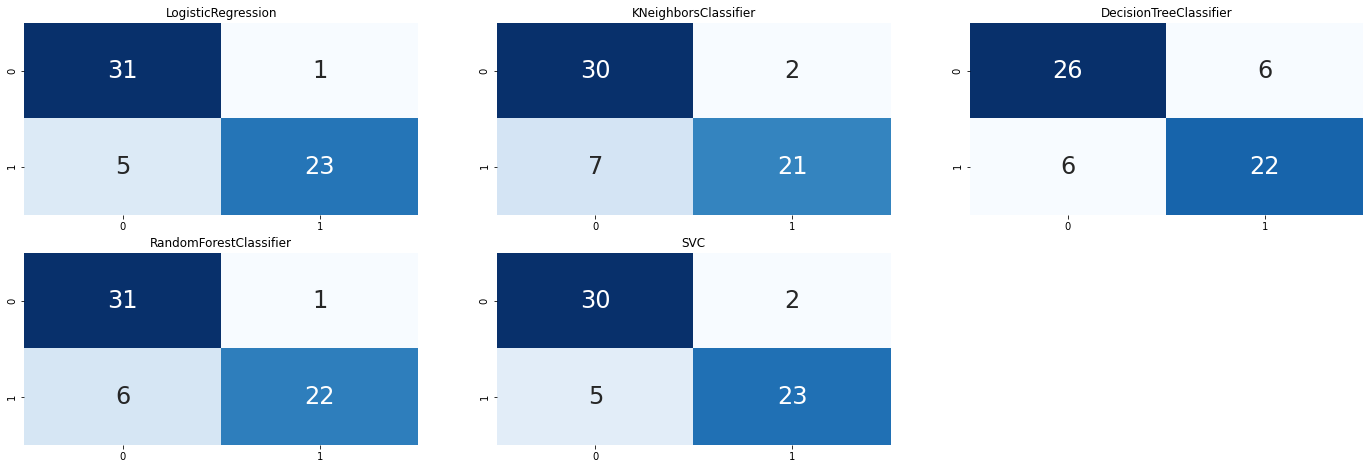

In [13]:
#Tworzenie tablicy zawierającej informacje o TP, FP, TN, FN
plt.figure(figsize=(24,12))
for i,name_model in enumerate(best_models.keys()):
    plt.subplot(3,3,i+1)
    y_pred_to_matrix = best_models[name_model][0].predict(X_test)
    lr_conf_matrix = confusion_matrix(y_test, y_pred_to_matrix)
    
    plt.title(f'{name_model}')
    sns.heatmap(lr_conf_matrix,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

### Wykres ROC

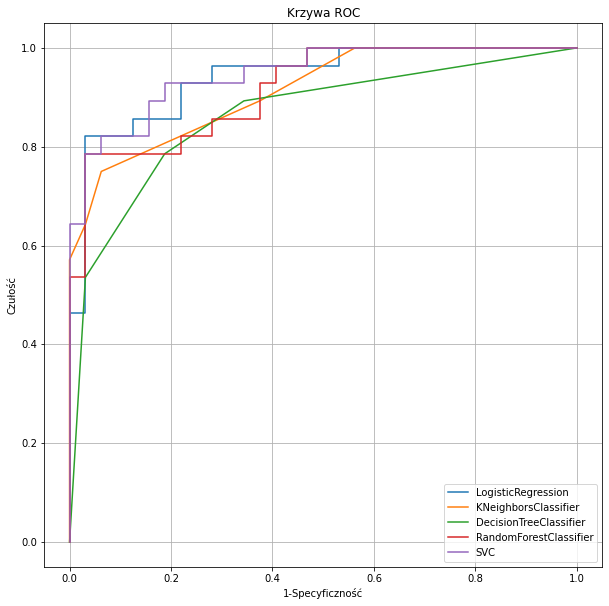

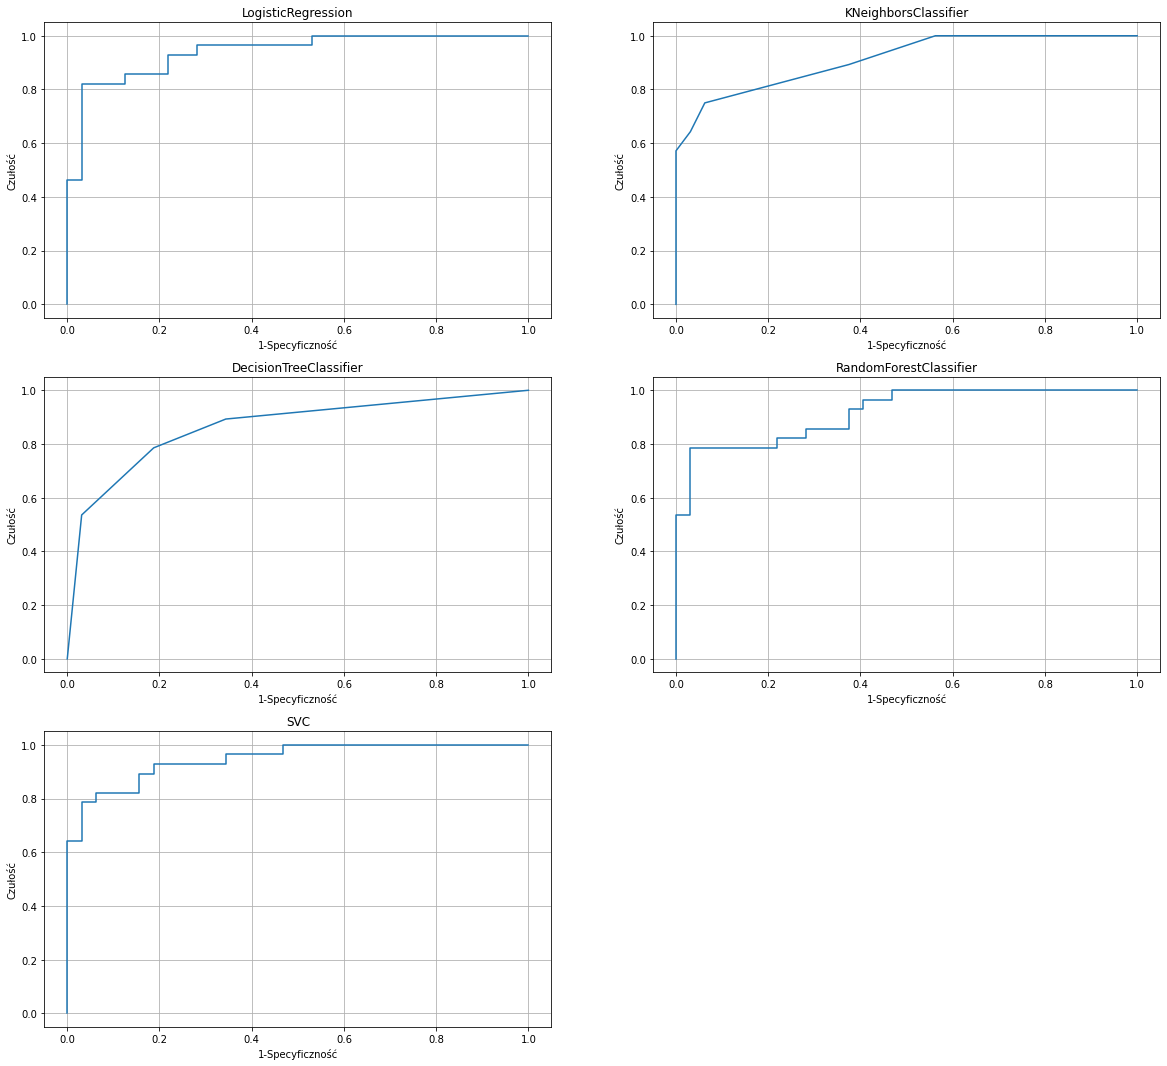

In [14]:
list_target_probabilities = {}# Słownik zawierjący ...
for name_model in best_models.keys():
    if name_model != 'SVC':
        list_target_probabilities[name_model] = best_models[name_model][0].predict_proba(X_test)[:,1]
    else:
        list_target_probabilities[name_model] = best_models[name_model][0].decision_function(X_test)
        
plt.figure(figsize=(10, 10))
for i in list_target_probabilities.keys():
    czulosci, specyficznosci, progi = roc_curve(y_test,list_target_probabilities[i])
    plt.plot(czulosci, specyficznosci) 
plt.legend(list_target_probabilities.keys())
plt.title("Krzywa ROC")
plt.xlabel("1-Specyficzność")
plt.ylabel("Czułość")
plt.grid() #Dodanie siatki
plt.show()# Wyrysowanie wykresu

plt.figure(figsize=(20,25))
for i,model_name in enumerate(list_target_probabilities.keys()):
    plt.subplot(4,2,i+1)
    czulosci, specyficznosci, progi = roc_curve(y_test,list_target_probabilities[model_name])
    plt.title(f"{model_name}")
    plt.xlabel("1-Specyficzność")
    plt.ylabel("Czułość")
    plt.grid() #Dodanie siatki
    plt.plot(czulosci, specyficznosci) 

### Krzywa nauki

### Cross - Validation na całym zbiorze

In [15]:
cv_scores = {}
for name_model in best_models.keys():
    cv_scores[name_model] = cross_val_score(best_models[name_model][0], X, y, cv=10)
    
for name_model in cv_scores.keys():
    print(f'{name_model} : {cv_scores[name_model].mean()}')

LogisticRegression : 0.8449425287356324
KNeighborsClassifier : 0.8110344827586207
DecisionTreeClassifier : 0.8011494252873564
RandomForestClassifier : 0.8413793103448276
SVC : 0.8482758620689657


In [16]:
for name_model in cv_scores.keys():
    print(f'{name_model} :\n {cv_scores[name_model]}')

LogisticRegression :
 [0.86666667 0.83333333 0.76666667 0.96666667 0.9        0.83333333
 0.8        0.93103448 0.72413793 0.82758621]
KNeighborsClassifier :
 [0.9        0.8        0.86666667 0.83333333 0.76666667 0.76666667
 0.86666667 0.82758621 0.68965517 0.79310345]
DecisionTreeClassifier :
 [0.83333333 0.83333333 0.9        0.86666667 0.83333333 0.6
 0.8        0.79310345 0.72413793 0.82758621]
RandomForestClassifier :
 [0.9        0.86666667 0.83333333 0.96666667 0.9        0.8
 0.73333333 0.86206897 0.68965517 0.86206897]
SVC :
 [0.9        0.86666667 0.8        0.93333333 0.86666667 0.83333333
 0.8        0.86206897 0.75862069 0.86206897]


<AxesSubplot:>

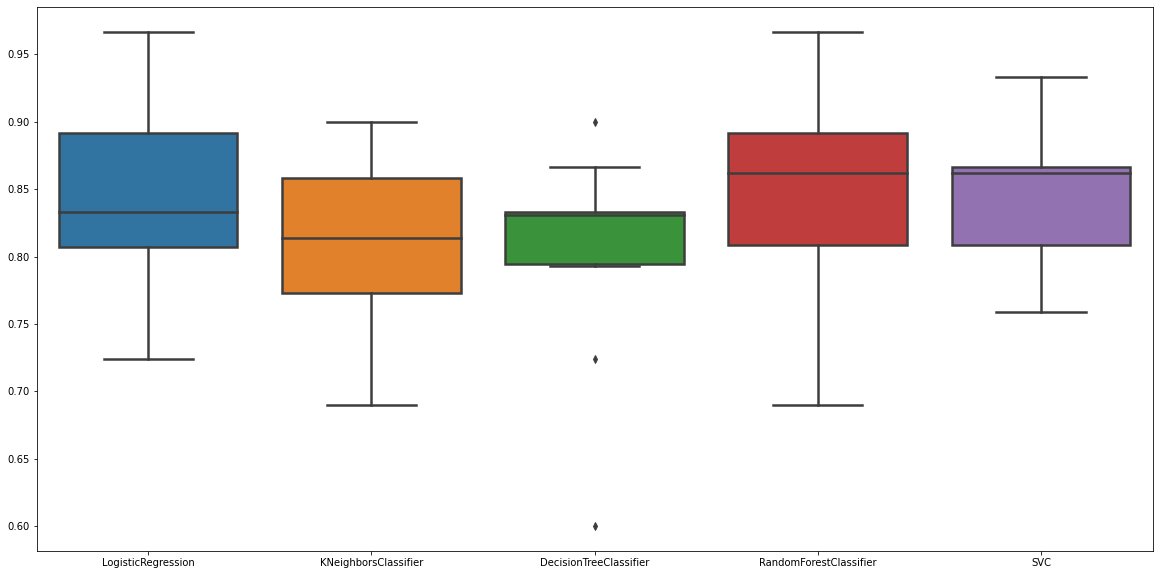

In [17]:
df_scores = pd.DataFrame(data=cv_scores)
plt.figure(figsize=(20,10))
sns.boxplot(data=df_scores, linewidth=2.5)

### Przetrenowanie algorytmów na całym zbiorze danych 

Przed dodaniem algorytmów na produkcje możemy przetrenować je za pomocą całego zbioru danych

In [18]:
for name_model in tqdm_notebook(best_models.keys(),desc='Algorithm Study'):
    best_models[name_model][0].fit(X,y)

Algorithm Study:   0%|          | 0/5 [00:00<?, ?it/s]

# Zapisanie najlepszych modeli z rozszerzeniem .bin

In [19]:
for name_model in best_models.keys():
    with open(f"./models/{name_model}.bin", 'wb') as f_out:
        pickle.dump(best_models[name_model][0], f_out) # write final_model in .bin file
        f_out.close()  # close the file 
    
with open('./models/SVC.bin', 'rb') as f_in:
    model = pickle.load(f_in)
    
model.score(X_test, y_test)


0.8833333333333333

# Testowanie, czy zapisany model działa 

In [20]:
patient = pd.DataFrame()
patient = patient.append(pd.DataFrame([[63.0,'male', 'typical angina',145.0,233.0,
                                        'greater than 120mg/ml', 'left ventricular hypertrophy', 
                                        150.0, 'no',2.3, 'downsloping', 0.0,'fixed defect']]))
patient.columns = ['age', 'sex', 'cp', 
               'trestbps', 'chol', 'fbs',
               'restecg', 'thalach', 'exang', 
               'oldpeak', 'slope', 'ca',
               'thal']
model.predict(patient)[0]

0